In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [2]:
column_name = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [3]:
df = pd.read_csv('data.csv', encoding='ISO-8859-1', names=column_name)

In [4]:
df.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.drop(['id', 'date', 'query', 'user'], axis=1, inplace=True)

In [6]:
df.shape

(1600000, 2)

In [10]:
df['sentiment'].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

In [11]:
df['sentiment'] = df['sentiment'].replace(4, 1)

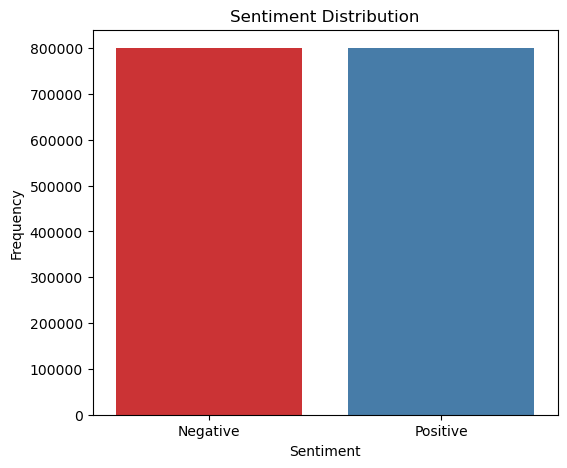

In [12]:
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(6, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Set1')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(range(len(sentiment_counts)), ['Negative', 'Positive'])
plt.show()

Tampak distribusi kelasnya seimbang sehingga tidak membutuhkan imbalanced data handling.

In [13]:
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [ ]:
def cleanText(text):
    cleanedText = []

    links = r'http\S+|www\S+|https\S+'
    userPattern = '@[^\s]+'
    apostrophe = r"'"
    nonWord = r'\W'
    singleCharacter = r'\s+[a-zA-Z]\s+'
    caretSymbol = r'\^[a-zA-Z]\s+'
    alphabet = "[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    multiSpace = r'\s+'

    text = text.lower()

    text = re.sub(links, ' ', text, flags=re.MULTILINE)

    text = re.sub(userPattern,' ', text)
    text = re.sub(apostrophe, '', text)
    text = re.sub(nonWord, ' ', text)
    text = re.sub(singleCharacter, ' ', text)
    text = re.sub(caretSymbol, ' ', text) 
    text = re.sub(alphabet, " ", text)
    text = re.sub(sequencePattern, seqReplacePattern, text)
    text = re.sub(multiSpace, ' ', text, flags=re.I)
    text = text.strip()
    
    wordLemm = WordNetLemmatizer()

    words = ''
    for word in text.split():
        if len(word)>1:
            if word != 'was':
                word = wordLemm.lemmatize(word)
            words += (word+' ')

    cleanedText.append(words)

    lemmatizedText = ' '.join(cleanedText)

    words = lemmatizedText.split()

    custom_stopwords = {'amp', 'quot', 'im', 'day'}
    words = [word for word in words if word not in custom_stopwords]

    cleaned_text = ' '.join(words)
    
    return cleaned_text

In [17]:
df['cleaned_text'] = df['text'].apply(lambda x: cleanText(x))

In [22]:
df.isnull().sum()

sentiment       0
text            0
cleaned_text    0
dtype: int64

In [23]:
df.dropna(inplace=True)

In [24]:
from wordcloud import WordCloud

positive_texts = df[df['sentiment'] == 1]['cleaned_text']
negative_texts = df[df['sentiment'] == 0]['cleaned_text']

positive_text_combined = " ".join(text for text in positive_texts)
negative_text_combined = " ".join(text for text in negative_texts)

wordcloud_positive = WordCloud(background_color="white").generate(positive_text_combined)
wordcloud_negative = WordCloud(background_color="white").generate(negative_text_combined)

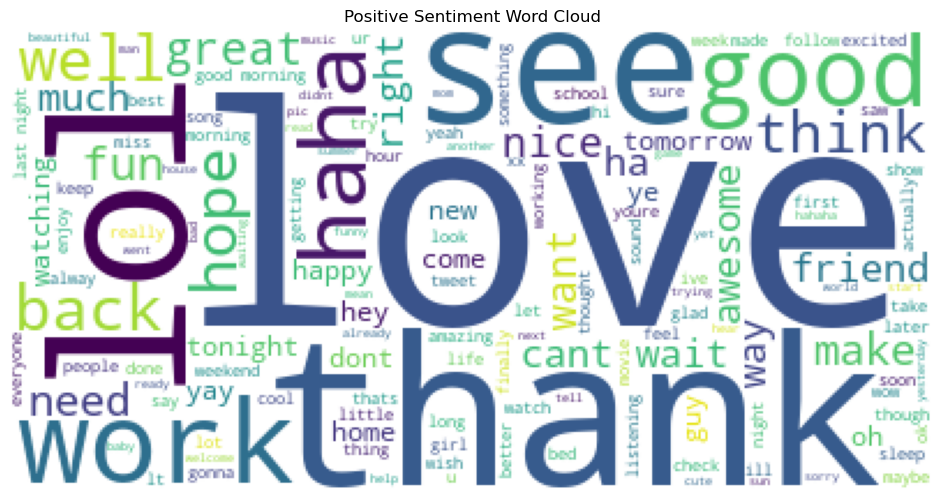

In [25]:
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_positive)
plt.title('Positive Sentiment Word Cloud')
plt.axis("off")
plt.show()

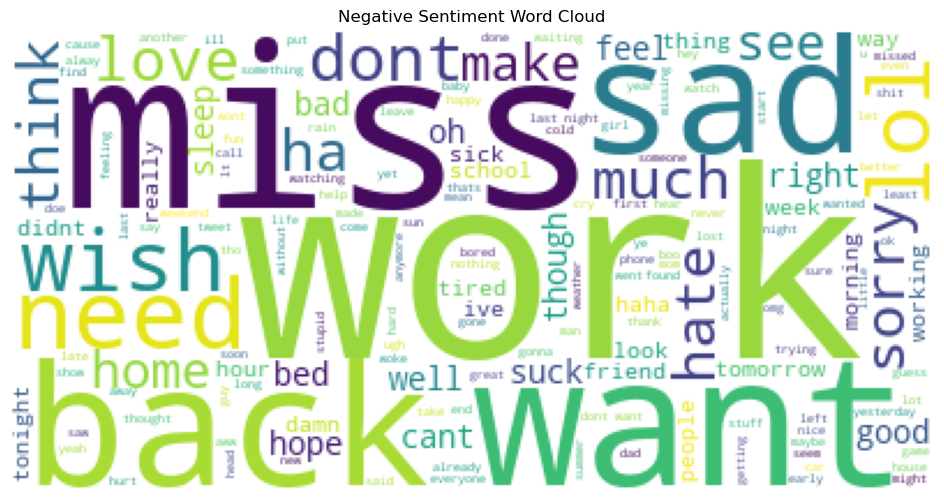

In [26]:
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_negative)
plt.title('Negative Sentiment Word Cloud')
plt.axis("off")
plt.show()

In [27]:
def get_top_ngrams(corpus, n=None, ngram_range=(2, 2)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [29]:
top_positive_bigrams = get_top_ngrams(positive_texts, n=10, ngram_range=(2, 2))
top_negative_bigrams = get_top_ngrams(negative_texts, n=10, ngram_range=(2, 2))

top_positive_bigrams, top_negative_bigrams

([('good morning', 8555),
  ('good luck', 3953),
  ('good night', 3942),
  ('looking forward', 3442),
  ('happy birthday', 3181),
  ('getting ready', 2830),
  ('look like', 2667),
  ('sound like', 2552),
  ('happy mother', 2075),
  ('feel like', 1907)],
 [('feel like', 6574),
  ('dont want', 5229),
  ('look like', 4427),
  ('dont think', 3474),
  ('dont like', 2792),
  ('dont wanna', 2704),
  ('sorry hear', 2466),
  ('feel better', 2319),
  ('looking forward', 2200),
  ('getting ready', 2199)])

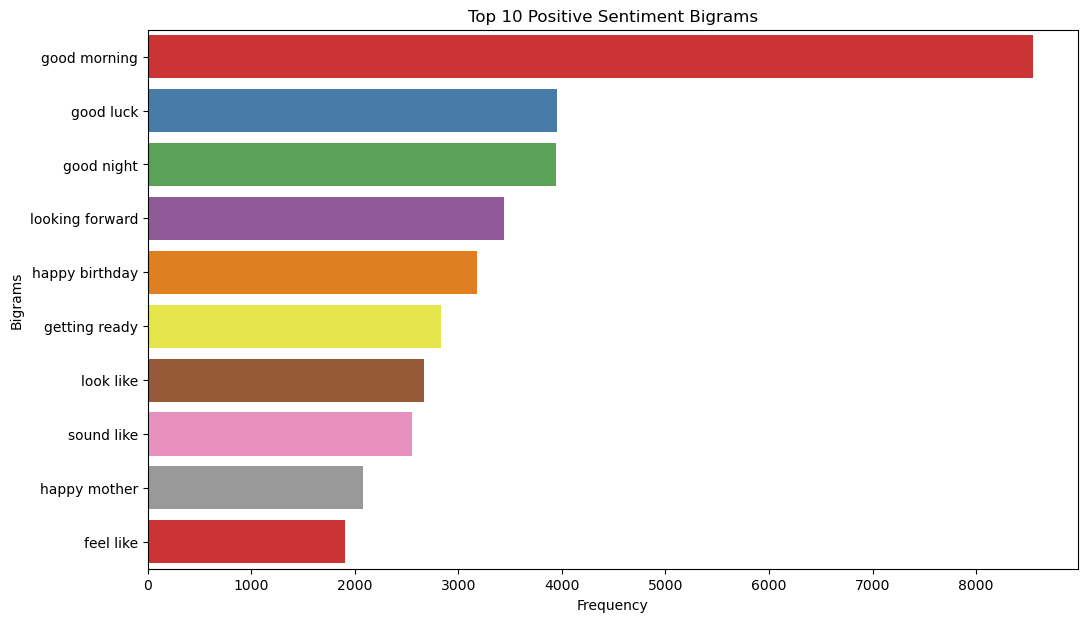

In [30]:
positive_bigrams, positive_counts = zip(*top_positive_bigrams)

plt.figure(figsize=(12, 7))

sns.barplot(x=list(positive_counts), y=list(positive_bigrams), palette='Set1')
plt.title('Top 10 Positive Sentiment Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')

plt.show()

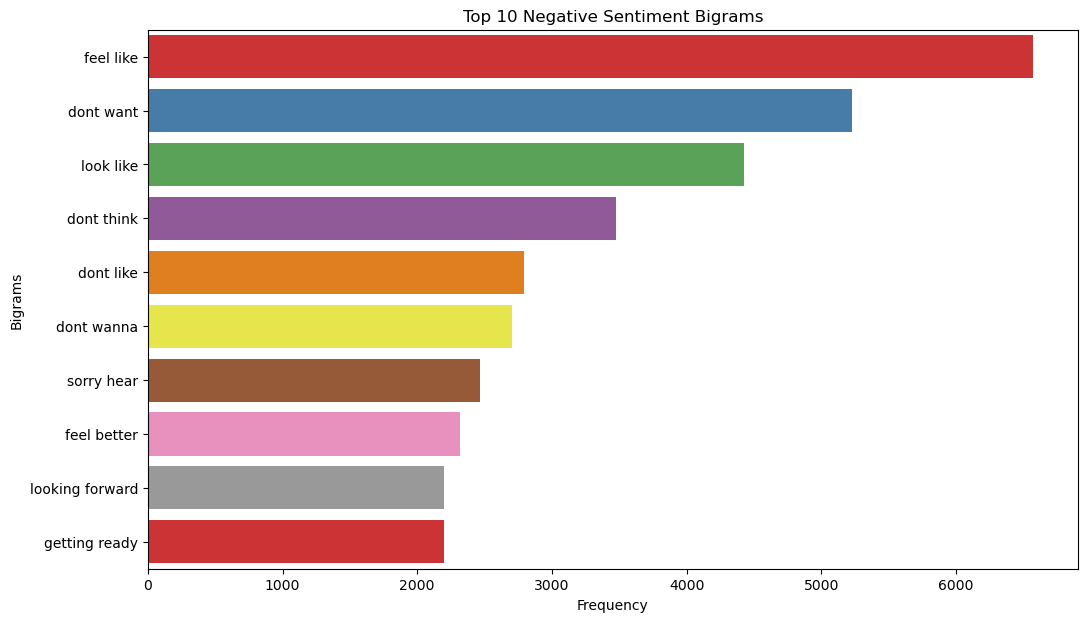

In [31]:
negative_bigrams, negative_counts = zip(*top_negative_bigrams)

plt.figure(figsize=(12, 7))

sns.barplot(x=list(negative_counts), y=list(negative_bigrams), palette='Set1')
plt.title('Top 10 Negative Sentiment Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')

plt.show()